## 11.2 항공 사진 내 선인장 식별 경진대회 탐색적 데이터 분석
- 항공 사진 내 선인장 식별 경진대회 링크

### 11.2.1 데이터 둘러보기

In [1]:
import pandas as pd

# 데이터 경로
data_path = '../input/2022-2-ds-solution-ch9/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
labels.shape, submission.shape

((14500, 2), (3000, 2))

In [2]:
labels.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


### 11.2.2 데이터 시각화

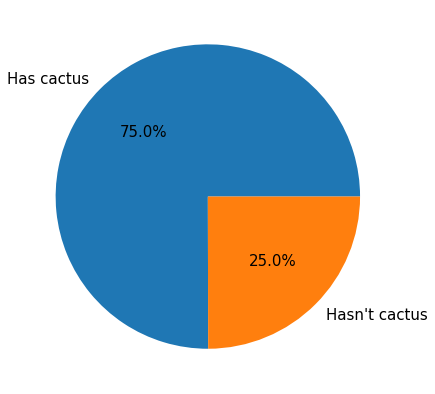

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=15)
plt.figure(figsize=(7, 7))

label = ['Has cactus', 'Hasn\'t cactus'] # 타깃값 레이블
# 타깃값 분포 파이 그래프
plt.pie(labels['has_cactus'].value_counts(), labels=label, autopct='%.1f%%');

이미지 로드 및 출력

In [4]:
import os
path_train = '../input/2022-2-ds-solution-ch9/train'
path_test = '../input/2022-2-ds-solution-ch9/test'

num_train = len(os.listdir(path_train))
num_test = len(os.listdir(path_test))

print(f'훈련 데이터 개수: {num_train}')
print(f'테스트 데이터 개수: {num_test}')

훈련 데이터 개수: 14500
테스트 데이터 개수: 3000


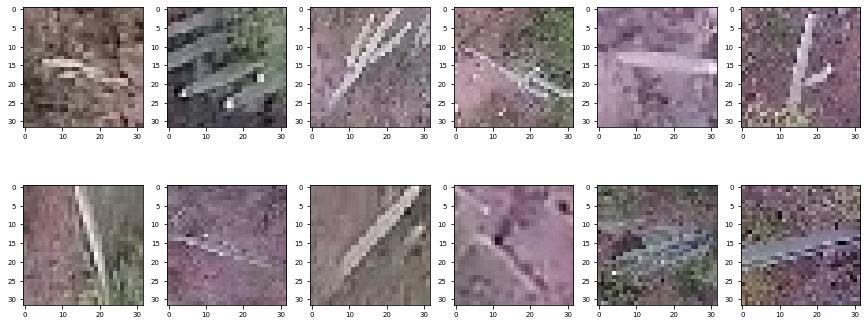

In [5]:
# 레이블이 1인 경우
import matplotlib.gridspec as gridspec
import cv2 # OpenCV 라이브러리 임포트

mpl.rc('font', size=7)
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치(2행 6열로 출력)
    
# 선인장을 포함하는 이미지 파일명(마지막 12개) 
last_has_cactus_img_name = labels[labels['has_cactus']==1]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_has_cactus_img_name):
    img_path = path_train+ '/' + img_name                 # 이미지 파일 경로 
    image = cv2.imread(img_path)                   # 이미지 파일 읽기 
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정 
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력 

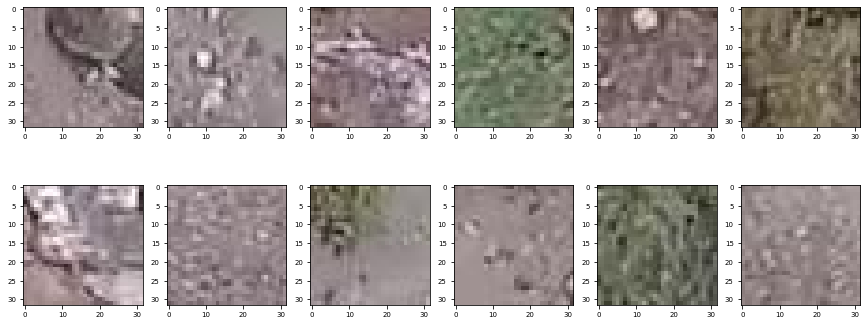

In [6]:
# 레이블이 0인 경우
plt.figure(figsize=(15, 6))    # 전체 Figure 크기 설정
grid = gridspec.GridSpec(2, 6) # 서브플롯 배치
    
# 선인장을 포함하지 않는 이미지 파일명(마지막 12개) 
last_hasnt_cactus_img_name = labels[labels['has_cactus']==0]['id'][-12:]

# 이미지 출력 
for idx, img_name in enumerate(last_hasnt_cactus_img_name):
    img_path = path_train+ '/' + img_name                 # 이미지 파일 경로
    image = cv2.imread(img_path)                   # 이미지 파일 읽기
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
    ax = plt.subplot(grid[idx])
    ax.imshow(image)                               # 이미지 출력 

## 11.3 항공 사진 내 선인장 식별 경진대회 베이스라인 모델


### 11.3.1 시드 값 고정 및 GPU 장비 설정

In [7]:
import torch # 파이토치 
import random
import numpy as np
import os

# 시드값 고정
seed = 50
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)                # 파이썬 난수 생성기 시드 고정
np.random.seed(seed)             # 넘파이 난수 생성기 시드 고정
torch.manual_seed(seed)          # 파이토치 난수 생성기 시드 고정 (CPU 사용 시)
torch.cuda.manual_seed(seed)     # 파이토치 난수 생성기 시드 고정 (GPU 사용 시)
torch.cuda.manual_seed_all(seed) # 파이토치 난수 생성기 시드 고정 (멀티GPU 사용 시)
torch.backends.cudnn.deterministic = True # 확정적 연산 사용
torch.backends.cudnn.benchmark = False    # 벤치마크 기능 해제
torch.backends.cudnn.enabled = False      # cudnn 사용 해제

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
device

device(type='cuda')

### 11.3.2 데이터 준비

In [9]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [10]:
print('훈련 데이터 개수:', len(train))
print('검증 데이터 개수:', len(valid))

훈련 데이터 개수: 13050
검증 데이터 개수: 1450


데이터셋 클래스 정의

In [11]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

데이터셋 생성

In [12]:
from torchvision import transforms # 이미지 변환을 위한 모듈

transform = transforms.ToTensor()
dataset_train = ImageDataset(df=train, img_dir=path_train+ '/', transform=transform)
dataset_valid = ImageDataset(df=valid, img_dir=path_train+ '/', transform=transform)
print("Train Length: {}, Eval Length: {}".format(len(dataset_train), len(dataset_valid)))

Train Length: 13050, Eval Length: 1450


In [13]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

print(len(loader_train))
for images, labels in loader_train:
    print(len(images))
    # 이미지, 레이블 데이터 미니배치를 장비에 할당 
    images = images.to(device)
    labels = labels.to(device)
    
    print(images[0])
    print(labels[0])
    
    break

408
32
tensor([[[0.7686, 0.8471, 0.7843,  ..., 0.4863, 0.5216, 0.6314],
         [0.7843, 0.7647, 0.7098,  ..., 0.4667, 0.4353, 0.4275],
         [0.7725, 0.7333, 0.7059,  ..., 0.5451, 0.4941, 0.4235],
         ...,
         [0.3451, 0.6784, 0.6706,  ..., 0.5765, 0.5686, 0.5647],
         [0.3059, 0.6431, 0.6706,  ..., 0.5765, 0.5725, 0.5686],
         [0.2667, 0.5098, 0.4980,  ..., 0.5765, 0.5725, 0.5686]],

        [[0.7608, 0.8392, 0.7725,  ..., 0.4275, 0.4627, 0.5725],
         [0.7765, 0.7569, 0.6980,  ..., 0.4078, 0.3765, 0.3686],
         [0.7686, 0.7294, 0.6941,  ..., 0.4863, 0.4353, 0.3647],
         ...,
         [0.3098, 0.6431, 0.6353,  ..., 0.5216, 0.5137, 0.5098],
         [0.2706, 0.6078, 0.6353,  ..., 0.5216, 0.5176, 0.5137],
         [0.2314, 0.4745, 0.4627,  ..., 0.5216, 0.5176, 0.5137]],

        [[0.8431, 0.9216, 0.8471,  ..., 0.4392, 0.4745, 0.5843],
         [0.8588, 0.8392, 0.7725,  ..., 0.4196, 0.3882, 0.3804],
         [0.8392, 0.8000, 0.7686,  ..., 0.4980, 0.4

### 11.3.3 모델 생성

In [14]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의 
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        
        # 첫 번째 합성곱 계층 
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, 
                               kernel_size=3, padding=2) 
        # 두 번째 합성곱 계층 
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, 
                               kernel_size=3, padding=2) 
        # 최대 풀링 계층 
        self.max_pool = nn.MaxPool2d(kernel_size=2) 
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=2) 
        # 전결합 계층 
        self.fc = nn.Linear(in_features=64 * 4 * 4, out_features=2)
        
    # 순전파 출력 정의 
    def forward(self, x):
        x = self.max_pool(F.relu(self.conv1(x)))
        x = self.max_pool(F.relu(self.conv2(x)))
        x = self.avg_pool(x)
        x = x.view(-1, 64 * 4 * 4) # 평탄화
        x = self.fc(x)
        return x

In [15]:
model = Model().to(device)

model

Model(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avg_pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (fc): Linear(in_features=1024, out_features=2, bias=True)
)

## 11.3.4 모델 훈련

In [16]:
# 손실함수
criterion = nn.CrossEntropyLoss()
# 옵티마이저
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [17]:
epochs = 10 # 총 에폭
# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    # 훈련 데이터 손실값 출력
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/10] - 손실값: 0.5292
에폭 [2/10] - 손실값: 0.3827
에폭 [3/10] - 손실값: 0.2723
에폭 [4/10] - 손실값: 0.2301
에폭 [5/10] - 손실값: 0.2089
에폭 [6/10] - 손실값: 0.1875
에폭 [7/10] - 손실값: 0.1769
에폭 [8/10] - 손실값: 0.1663
에폭 [9/10] - 손실값: 0.1524
에폭 [10/10] - 손실값: 0.1471


### 11.3.5 성능 검증

In [18]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device) 
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률  
        true = labels.cpu() # 실제값 
        # 예측 확률과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}')

검증 데이터 ROC AUC : 0.9916


In [19]:
preds_list[0:10]

[tensor(0.9981),
 tensor(0.9999),
 tensor(1.0000),
 tensor(0.9481),
 tensor(0.9999),
 tensor(0.9999),
 tensor(0.0765),
 tensor(0.9254),
 tensor(0.9987),
 tensor(0.0130)]

In [20]:
true_list[0:10]

[tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(1),
 tensor(0),
 tensor(1),
 tensor(1),
 tensor(0)]

### 모델 성능 개선

- 성능개선1 : https://www.kaggle.com/code/werooring/ch11-modeling

- 성능개선2 : https://www.kaggle.com/code/werooring/ch11-modeling2

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
import pandas as pd

# 데이터 경로
data_path = '../input/2022-2-ds-solution-ch9/'

labels = pd.read_csv(data_path + 'train.csv')
submission = pd.read_csv(data_path + 'sample_submission.csv')
labels.shape, submission.shape

((14500, 2), (3000, 2))

In [23]:
from sklearn.model_selection import train_test_split

# 훈련 데이터, 검증 데이터 분리
train, valid = train_test_split(labels, 
                                test_size=0.1,
                                stratify=labels['has_cactus'],
                                random_state=50)

In [24]:
import cv2 # OpenCV 라이브러리
from torch.utils.data import Dataset # 데이터 생성을 위한 클래스

class ImageDataset(Dataset):
    # 초기화 메서드(생성자)
    def __init__(self, df, img_dir='./', transform=None):
        super().__init__() # 상속받은 Dataset의 생성자 호출
        # 전달받은 인수들 저장
        self.df = df
        self.img_dir = img_dir
        self.transform = transform
    
    # 데이터셋 크기 반환 메서드 
    def __len__(self):
        return len(self.df)
    
    # 인덱스(idx)에 해당하는 데이터 반환 메서드 
    def __getitem__(self, idx):
        img_id = self.df.iloc[idx, 0]    # 이미지 ID
        img_path = self.img_dir + img_id # 이미지 파일 경로 
        image = cv2.imread(img_path)     # 이미지 파일 읽기 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # 이미지 색상 보정
        label = self.df.iloc[idx, 1]     # 이미지 레이블(타깃값)

        if self.transform is not None:
            image = self.transform(image) # 변환기가 있다면 이미지 변환
        return image, label

In [25]:
from torchvision import transforms # 이미지 변환을 위한 모듈

# 훈련 데이터용 변환기
transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Pad(32, padding_mode='symmetric'),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomRotation(10),
                                      transforms.Normalize((0.485, 0.456, 0.406),
                                                           (0.229, 0.224, 0.225))])

# 검증 및 테스트 데이터용 변환기
transform_test= transforms.Compose([transforms.ToTensor(),
                                    transforms.Pad(32, padding_mode='symmetric'),
                                    transforms.Normalize((0.485, 0.456, 0.406),
                                                         (0.229, 0.224, 0.225))])

In [26]:
dataset_train = ImageDataset(df=train, img_dir=path_train + '/', transform=transform_train)
dataset_valid = ImageDataset(df=valid, img_dir=path_train + '/', transform=transform_test)

In [27]:
from torch.utils.data import DataLoader # 데이터 로더 클래스

loader_train = DataLoader(dataset=dataset_train, batch_size=32, shuffle=True)
loader_valid = DataLoader(dataset=dataset_valid, batch_size=32, shuffle=False)

In [28]:
import torch.nn as nn # 신경망 모듈
import torch.nn.functional as F # 신경망 모듈에서 자주 사용되는 함수

class Model(nn.Module):
    # 신경망 계층 정의
    def __init__(self):
        super().__init__() # 상속받은 nn.Module의 __init__() 메서드 호출
        # 1 ~ 5번째 {합성곱, 배치 정규화, 최대 풀링} 계층 
        self.layer1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=32,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(32), # 배치 정규화
                                    nn.LeakyReLU(), # LeakyReLU 활성화 함수
                                    nn.MaxPool2d(kernel_size=2))

        self.layer2 = nn.Sequential(nn.Conv2d(in_channels=32, out_channels=64,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(64),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        self.layer3 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer4 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(256),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        
        self.layer5 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                              kernel_size=3, padding=2),
                                    nn.BatchNorm2d(512),
                                    nn.LeakyReLU(),
                                    nn.MaxPool2d(kernel_size=2))
        # 평균 풀링 계층 
        self.avg_pool = nn.AvgPool2d(kernel_size=4) 
        # 전결합 계층
        self.fc1 = nn.Linear(in_features=512 * 1 * 1, out_features=64)
        self.fc2 = nn.Linear(in_features=64, out_features=2)

    # 순전파 출력 정의 
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512 * 1 * 1) # 평탄화
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [29]:
model = Model().to(device)

In [30]:
# 손실 함수
criterion = nn.CrossEntropyLoss()

# 옵티마이저
optimizer = torch.optim.Adamax(model.parameters(), lr=0.00006)

In [31]:
epochs = 70 # 총 에폭

# 총 에폭만큼 반복
for epoch in range(epochs):
    epoch_loss = 0 # 에폭별 손실값 초기화
    
    # '반복 횟수'만큼 반복 
    for images, labels in loader_train:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 옵티마이저 내 기울기 초기화
        optimizer.zero_grad()
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 손실 함수를 활용해 outputs와 labels의 손실값 계산
        loss = criterion(outputs, labels)
        # 현재 배치에서의 손실 추가
        epoch_loss += loss.item() 
        # 역전파 수행
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
    print(f'에폭 [{epoch+1}/{epochs}] - 손실값: {epoch_loss/len(loader_train):.4f}')

에폭 [1/70] - 손실값: 0.1255
에폭 [2/70] - 손실값: 0.0681
에폭 [3/70] - 손실값: 0.0551
에폭 [4/70] - 손실값: 0.0449
에폭 [5/70] - 손실값: 0.0414
에폭 [6/70] - 손실값: 0.0364
에폭 [7/70] - 손실값: 0.0343
에폭 [8/70] - 손실값: 0.0278
에폭 [9/70] - 손실값: 0.0263
에폭 [10/70] - 손실값: 0.0268
에폭 [11/70] - 손실값: 0.0240
에폭 [12/70] - 손실값: 0.0218
에폭 [13/70] - 손실값: 0.0193
에폭 [14/70] - 손실값: 0.0203
에폭 [15/70] - 손실값: 0.0207
에폭 [16/70] - 손실값: 0.0166
에폭 [17/70] - 손실값: 0.0176
에폭 [18/70] - 손실값: 0.0176
에폭 [19/70] - 손실값: 0.0136
에폭 [20/70] - 손실값: 0.0169
에폭 [21/70] - 손실값: 0.0142
에폭 [22/70] - 손실값: 0.0161
에폭 [23/70] - 손실값: 0.0149
에폭 [24/70] - 손실값: 0.0134
에폭 [25/70] - 손실값: 0.0143
에폭 [26/70] - 손실값: 0.0124
에폭 [27/70] - 손실값: 0.0106
에폭 [28/70] - 손실값: 0.0110
에폭 [29/70] - 손실값: 0.0118
에폭 [30/70] - 손실값: 0.0106
에폭 [31/70] - 손실값: 0.0096
에폭 [32/70] - 손실값: 0.0103
에폭 [33/70] - 손실값: 0.0097
에폭 [34/70] - 손실값: 0.0090
에폭 [35/70] - 손실값: 0.0093
에폭 [36/70] - 손실값: 0.0099
에폭 [37/70] - 손실값: 0.0096
에폭 [38/70] - 손실값: 0.0096
에폭 [39/70] - 손실값: 0.0090
에폭 [40/70] - 손실값: 0.0078
에폭 [41/70

In [32]:
from sklearn.metrics import roc_auc_score # ROC AUC 점수 계산 함수 임포트

# 실제값과 예측 확률값을 담을 리스트 초기화
true_list = []
preds_list = []

model.eval() # 모델을 평가 상태로 설정 

with torch.no_grad(): # 기울기 계산 비활성화
    for images, labels in loader_valid:
        # 이미지, 레이블 데이터 미니배치를 장비에 할당 
        images = images.to(device)
        labels = labels.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        preds = torch.softmax(outputs.cpu(), dim=1)[:, 1] # 예측 확률값
        true = labels.cpu() # 실제값 
        # 예측 확률값과 실제값을 리스트에 추가
        preds_list.extend(preds)
        true_list.extend(true)
        
# 검증 데이터 ROC AUC 점수 계산 
print(f'검증 데이터 ROC AUC : {roc_auc_score(true_list, preds_list):.4f}') 

검증 데이터 ROC AUC : 0.9982


In [33]:
dataset_test = ImageDataset(df=submission, img_dir=path_test + '/', 
                            transform=transform_test)
loader_test = DataLoader(dataset=dataset_test, batch_size=32, shuffle=False)

# 예측 수행
model.eval() # 모델을 평가 상태로 설정

preds = [] # 타깃 예측값 저장용 리스트 초기화

with torch.no_grad(): # 기울기 계산 비활성화
    for images, _ in loader_test:
        # 이미지 데이터 미니배치를 장비에 할당
        images = images.to(device)
        
        # 순전파 : 이미지 데이터를 신경망 모델의 입력값으로 사용해 출력값 계산
        outputs = model(images)
        # 타깃값이 1일 확률(예측값)
        preds_part = torch.softmax(outputs.cpu(), dim=1)[:, 1].tolist()
        # preds에 preds_part 이어붙이기
        preds.extend(preds_part)

In [34]:
submission['has_cactus'] = preds
submission.to_csv('submission.csv', index=False)